## Import packages

In [1]:
import numpy as np 
import csv 
import glob
import pandas as pd
import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import math

## Select model class and type

In [2]:
model = "AI_ddm" # RL, RL_ddm, RL_ddm_biased, AI, or AI_ddm
mtype = 1 # 0, 1, 2 or 3 (only relevant if model = AI or AI_ddm)
drmtype = "linear" # Drift rate model: linear, sigmoid, sigmoid_single_v_mod, sigmoid_single_v_max
dataset = 'magic_carpet_2020' 
n_starts = 35

if model in ("RL", "RL_ddm", "RL_ddm_biased"):
    learning = "RL"
elif model in ("AI", "AI_ddm"):
    learning = "PSM" 

## Import fitted parameters

In [4]:
# Path to dataset folder
current_dir = os.getcwd()

# Path to where the csv file is relative to the current script's directory

if model == "RL":
    path_to_folder = (os.path.join(current_dir, 'param_recovery_data/' + dataset + '/model_' + model +'/'))
    file_path = os.path.join(path_to_folder, "param_recovery_results_M" + model + "_n_starts" + str(n_starts) + ".csv")
elif model == "RL_ddm":
    path_to_folder = (os.path.join(current_dir, 'param_recovery_data/' + dataset + '/model_' + model + '_DRM' + drmtype + '/'))
    file_path = os.path.join(path_to_folder, "param_recovery_results_M" + model + '_DRM' + drmtype + "_n_starts" + str(n_starts) + ".csv")
elif model == "AI":
    path_to_folder = (os.path.join(current_dir, 'param_recovery_data/' + dataset + '/model_' + model + str(mtype) + '/'))
    file_path = os.path.join(path_to_folder, "param_recovery_results_M" + model + str(mtype) + "_n_starts" + str(n_starts) + ".csv")
elif model == "AI_ddm": 
    path_to_folder = (os.path.join(current_dir, 'param_recovery_data/' + dataset + '/model_' + model + str(mtype) + '_DRM' + drmtype + '/'))
    file_path = os.path.join(path_to_folder, "param_recovery_results_M" + model + str(mtype) + '_DRM' + drmtype + "_n_starts" + str(n_starts) + ".csv")

df_fitted_params = pd.read_csv(file_path)


## Helper function

In [5]:
def plot_parameter_recovery_resuts(df):
    
    columns = df.columns
    
    param_names = [col.replace("Recovered_", "") for col in columns if col.startswith("Recovered_")]

    for param in param_names:
        plt.figure(figsize=(3, 3))
        
        plt.scatter(df['Synthetic_' + param], df['Recovered_' + param], label=f'{param}')
        
        max_val = max(df['Synthetic_' + param].max(), df['Recovered_' + param].max())
        min_val = min(df['Synthetic_' + param].min(), df['Recovered_' + param].min())

        plt.plot([0, max_val], [0, max_val], linestyle='-', color='red', linewidth=0.5)

        if param == 'ndt':
            param_string = r"$t_{\text{nd}}$"
        elif param == 'lr':
            param_string = r"$l$"
        elif param == 'vunsamp':
            param_string = r"$v_{\text{DU}}$"
        elif param == 'vsamp':
            param_string = r"$v_{\text{DS}}$"
        elif param == 'vps':
            param_string = r"$v_{\text{PS}}$"
        elif param == 'gamma1':
            param_string = r"$\gamma_1$"
        elif param == 'gamma2': 
            param_string = r"$\gamma_2$"
        elif param == 'lam': 
            param_string = r"$\lambda$"
        elif param == "kappa_a":
            param_string = r"$\kappa$"
        elif param == "prior_r":
            param_string = r"$p_{r}$"
        elif param ==  "a_bs":
            param_string = r"$a_{\text{bs}}$"
        elif param == "v_stage_0":
            param_string = r"$v^{\text{mod}}_1$"
        elif param == "v_stage_1":
            param_string = r"$v^{\text{mod}}_2$"


        if model == "RL":
            model_string = "RL"
        elif model == "RL_ddm":
            model_string = "$\text{RL-DDM}$"
        elif model == "AI_ddm":
            if mtype == 0:  
                model_string = r"$\text{AIF-DDM}_{\text{FULL}}$"
            elif mtype == 1:
                model_string = r"$\text{AIF-DDM}_{\text{NSD}}$"
            elif mtype == 2:
                model_string = r"$\text{AIF-DDM}_{\text{NUD}}$"
            elif mtype == 3:
                model_string = r"$\text{AIF-DDM}_{\text{NSL}}$"
        elif model == "AI":
            if mtype == 0:  
                model_string = r"$\text{AIF}_{\text{FULL}}$"
            elif mtype == 1:
                model_string = r"$\text{AIF}_{\text{NSD}}$"
            elif mtype == 2:
                model_string = r"$\text{AIF}_{\text{NUD}}$"
            elif mtype == 3:
                model_string = r"$\text{AIF}_{\text{NSL}}$"

    
        plt.title(f"{model_string}: {param_string}", fontsize=16)
            

        plt.gca().set_aspect('equal', adjustable='box')

        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)


        plt.xlabel(f"Synthetic", fontsize=16)
        plt.ylabel(f"Recovered", fontsize=16)

        if model in ["RL", "RL_ddm", "RL_ddm_biased"]:  
            plot_filename = f"recovery_plot_{model}_{param}.png" 
            output_dir = f"../paper_figures/parameter_recovery/{model}/" 
        else:
            plot_filename = f"recovery_plot_{model}{mtype}_{param}.png" 
            output_dir = f"../paper_figures/parameter_recovery/{model}{mtype}/" 
         
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        full_plot_path = os.path.join(output_dir, plot_filename)

        plt.savefig(full_plot_path, dpi=300, bbox_inches='tight')

        plt.show()

        plt.close()

In [6]:
def plot_parameter_recovery_results_grid(df, model, mtype=None, desired_rows=2):
    """
    Plots parameter recovery results for all parameters in a single figure with a grid layout.

    Args:
        df (pd.DataFrame): DataFrame containing 'Synthetic_<param>' and 'Recovered_<param>' columns.
        model (str): The name of the model (e.g., "RL", "AI_ddm").
        mtype (int, optional): Model type, used for specific model naming (e.g., for AI_ddm variants).
                               Defaults to None.
        desired_rows (int): The number of rows you'd ideally like in your subplot grid.
                            The number of columns will be calculated based on this and total parameters.
    """
    columns = df.columns
    param_names = sorted([col.replace("Recovered_", "") for col in columns if col.startswith("Recovered_")]) # Sort for consistent order

    if not param_names:
        print("No 'Recovered_...' columns found in DataFrame. Nothing to plot.")
        return

    num_params = len(param_names)
    
    # Determine grid size
    # desired_rows = 2 # You can make this an argument if you want more flexibility
    ncols = math.ceil(num_params / desired_rows)
    nrows = math.ceil(num_params / ncols) # Recalculate rows to be efficient if ncols forces fewer rows

    # Adjust figure size based on number of subplots for better readability
    # These are heuristic values, you might need to fine-tune them
    base_fig_width_per_col = 3.5
    base_fig_height_per_row = 3.5
    fig_width = ncols * base_fig_width_per_col
    fig_height = nrows * base_fig_height_per_row
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), squeeze=False)
    # `squeeze=False` ensures `axes` is always a 2D array, even if nrows or ncols is 1.
    axes = axes.flatten() # Flatten to make iterating easier

    # Determine model string once
    model_string_base = "" # For filename
    model_string_title = ""  # For plot title
    if model == "RL":
        model_string_base = model_string_title = "RL"
    elif model == "RL_ddm":
        model_string_base = model_string_title = "RL-DDM"
    elif model == "RL_ddm_biased": # Added this as per your filename logic
        model_string_base = model_string_title = "RL-DDM_Biased" # Or however you want to represent it
    elif model == "AI_ddm":
        model_string_base = f"{model}{mtype if mtype is not None else ''}"
        if mtype == 0: model_string_title = r"$\text{AIF-DDM}_{\text{FULL}}$"
        elif mtype == 1: model_string_title = r"$\text{AIF-DDM}_{\text{NSD}}$"
        elif mtype == 2: model_string_title = r"$\text{AIF-DDM}_{\text{NUD}}$"
        elif mtype == 3: model_string_title = r"$\text{AIF-DDM}_{\text{NSL}}$"
        else: model_string_title = r"$\text{AIF-DDM}$" # Fallback
    elif model == "AI":
        model_string_base = f"{model}{mtype if mtype is not None else ''}"
        if mtype == 0: model_string_title = r"$\text{AIF}_{\text{FULL}}$"
        elif mtype == 1: model_string_title = r"$\text{AIF}_{\text{NSD}}$"
        elif mtype == 2: model_string_title = r"$\text{AIF}_{\text{NUD}}$"
        elif mtype == 3: model_string_title = r"$\text{AIF}_{\text{NSL}}$"
        else: model_string_title = r"$\text{AIF}$" # Fallback
    else:
        model_string_base = model_string_title = model # Fallback


    for i, param in enumerate(param_names):
        ax = axes[i] # Get the current subplot axis

        ax.scatter(df['Synthetic_' + param], df['Recovered_' + param], label=f'{param}', s=20) # s for marker size

        max_val = max(df['Synthetic_' + param].max(), df['Recovered_' + param].max())
        min_val = min(df['Synthetic_' + param].min(), df['Recovered_' + param].min())

        # Ensure min_val is not equal to max_val, add padding
        if min_val == max_val:
            padding = 0.1 * abs(max_val) if max_val != 0 else 0.1
            min_val -= padding
            max_val += padding
            if min_val == 0 and max_val == 0: # if originally both were 0
                min_val = -0.1
                max_val = 0.1

        # Use min_val and max_val for the 1-1 line to be general
        ax.plot([min_val, max_val], [min_val, max_val], linestyle='-', color='red', linewidth=0.7)

        param_string = ""
        if param == 'ndt': param_string = r"$t_{\text{nd}}$"
        elif param == 'lr': param_string = r"$l$"
        elif param == 'vunsamp': param_string = r"$v_{\text{DU}}$"
        elif param == 'vsamp': param_string = r"$v_{\text{DS}}$"
        elif param == 'vps': param_string = r"$v_{\text{PS}}$"
        elif param == 'gamma1': param_string = r"$\gamma_1$"
        elif param == 'gamma2': param_string = r"$\gamma_2$"
        elif param == 'lam': param_string = r"$\lambda$"
        elif param == "kappa_a": param_string = r"$\kappa$"
        elif param == "prior_r": param_string = r"$p_{r}$"
        elif param == "a_bs": param_string = r"$a_{\text{bs}}$"
        elif param == "v_stage_0": param_string = r"$v^{\text{mod}}_1$"
        elif param == "v_stage_1": param_string = r"$v^{\text{mod}}_2$"
        else: param_string = param # Fallback for unknown params

        ax.set_title(f"{param_string}", fontsize=14) # Title is just param, model is in suptitle
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
        ax.tick_params(axis='both', which='major', labelsize=10) # Smaller ticks for subplots

        # Set x/y labels only for edge plots to reduce clutter
        # Determine if the subplot is on the left edge (for y-label)
        if i % ncols == 0:
            ax.set_ylabel("Recovered", fontsize=12)
        
        # Determine if the subplot is on the bottom edge (for x-label)
        # This is true if i >= num_params - ncols
        # (e.g. for 11 params, 2 rows, 6 cols: params 0-5 on top, 6-10 on bottom.
        #  So labels for params 5 (if it's the last in 1st row of full grid) or 6,7,8,9,10)
        # More accurately: if the subplot is in the last *plotted* row.
        # The last plotted row starts at index: (nrows_with_plots - 1) * ncols
        
        # Calculate actual number of rows that will have plots
        actual_nrows_with_plots = math.ceil(num_params / ncols)
        if i // ncols == actual_nrows_with_plots - 1: # If in the last row with plots
             ax.set_xlabel("Synthetic", fontsize=12)
        elif num_params <= ncols and i // ncols == 0: # Single row of plots
             ax.set_xlabel("Synthetic", fontsize=12)


    # Hide any unused subplots
    for j in range(num_params, nrows * ncols):
        fig.delaxes(axes[j]) # or axes[j].axis('off')

    # Add an overall title for the model
    fig.suptitle(f"Parameter Recovery: {model_string_title}", fontsize=18, y=1.02) # y to adjust position

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # rect to make space for suptitle

    # --- Saving the entire figure ---
    if model in ["RL", "RL_ddm", "RL_ddm_biased"]:
        plot_filename = f"recovery_summary_{model}.png"
        output_dir = f"../paper_figures/parameter_recovery/{model}/"
    else: # Assumes AI, AI_ddm etc. where mtype is relevant
        # Use the base model string which includes mtype for filename consistency
        plot_filename = f"recovery_summary_{model_string_base}.png"
        output_dir = f"../paper_figures/parameter_recovery/{model_string_base}/"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True) # exist_ok=True avoids error if dir exists

    full_plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(full_plot_path, dpi=300, bbox_inches='tight')
    print(f"Grid plot saved to: {full_plot_path}")

    plt.show()
    plt.close(fig) # Close the figure object


In [7]:
def calculate_pearsons_correlations(df):
    
    # Extract parameter names 
    param_names = [col.replace("Recovered_", "") for col in df.columns if col.startswith("Recovered_")]

    correlations = []
    
    # Calculate Pearson correlation and p-value for each parameter
    for param in param_names:
        synthetic_vals = df['Synthetic_' + param]
        recovered_vals = df['Recovered_' + param]
        
        corr, p_value = pearsonr(synthetic_vals, recovered_vals)

        p_value_formatted = "{:.3g}".format(p_value)
        
        # Store the parameter name, correlation, and p-value as a tuple
        correlations.append((param, corr, p_value_formatted))
    
    # Convert the list to a DataFrame with columns for parameter, correlation, and p-value
    corr_df = pd.DataFrame(correlations, columns=['Parameter', 'Pearson Correlation', 'p-value'])
    
    return corr_df

## Plot results

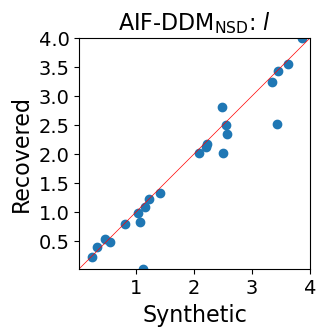

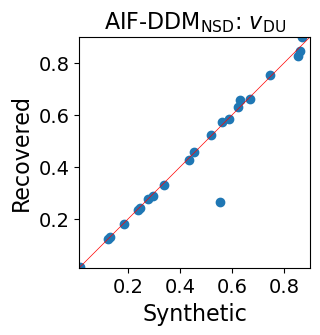

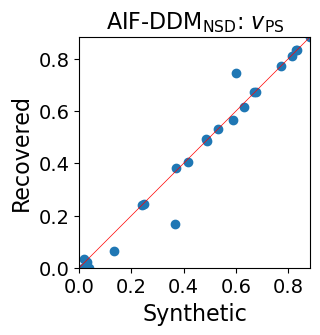

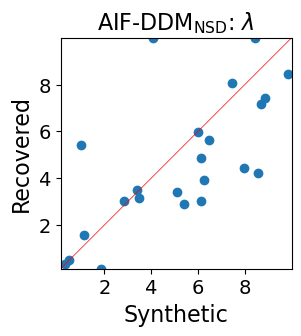

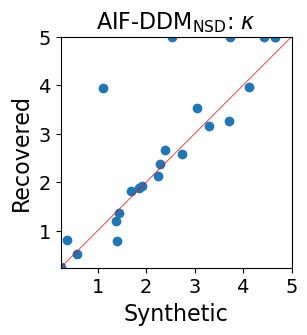

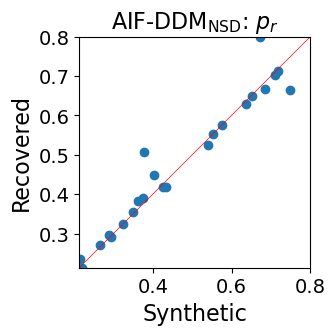

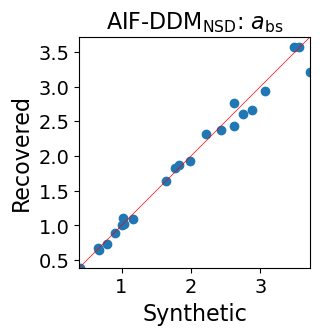

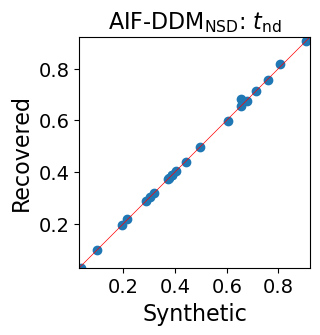

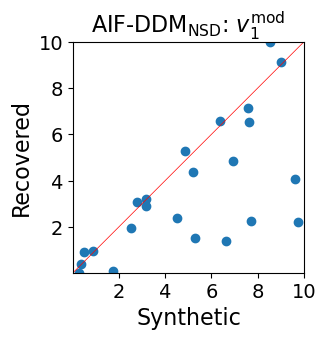

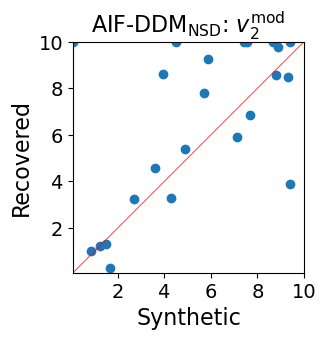

In [8]:
plot_parameter_recovery_resuts(df_fitted_params)

Grid plot saved to: ../paper_figures/parameter_recovery/AI_ddm1/recovery_summary_AI_ddm1.png


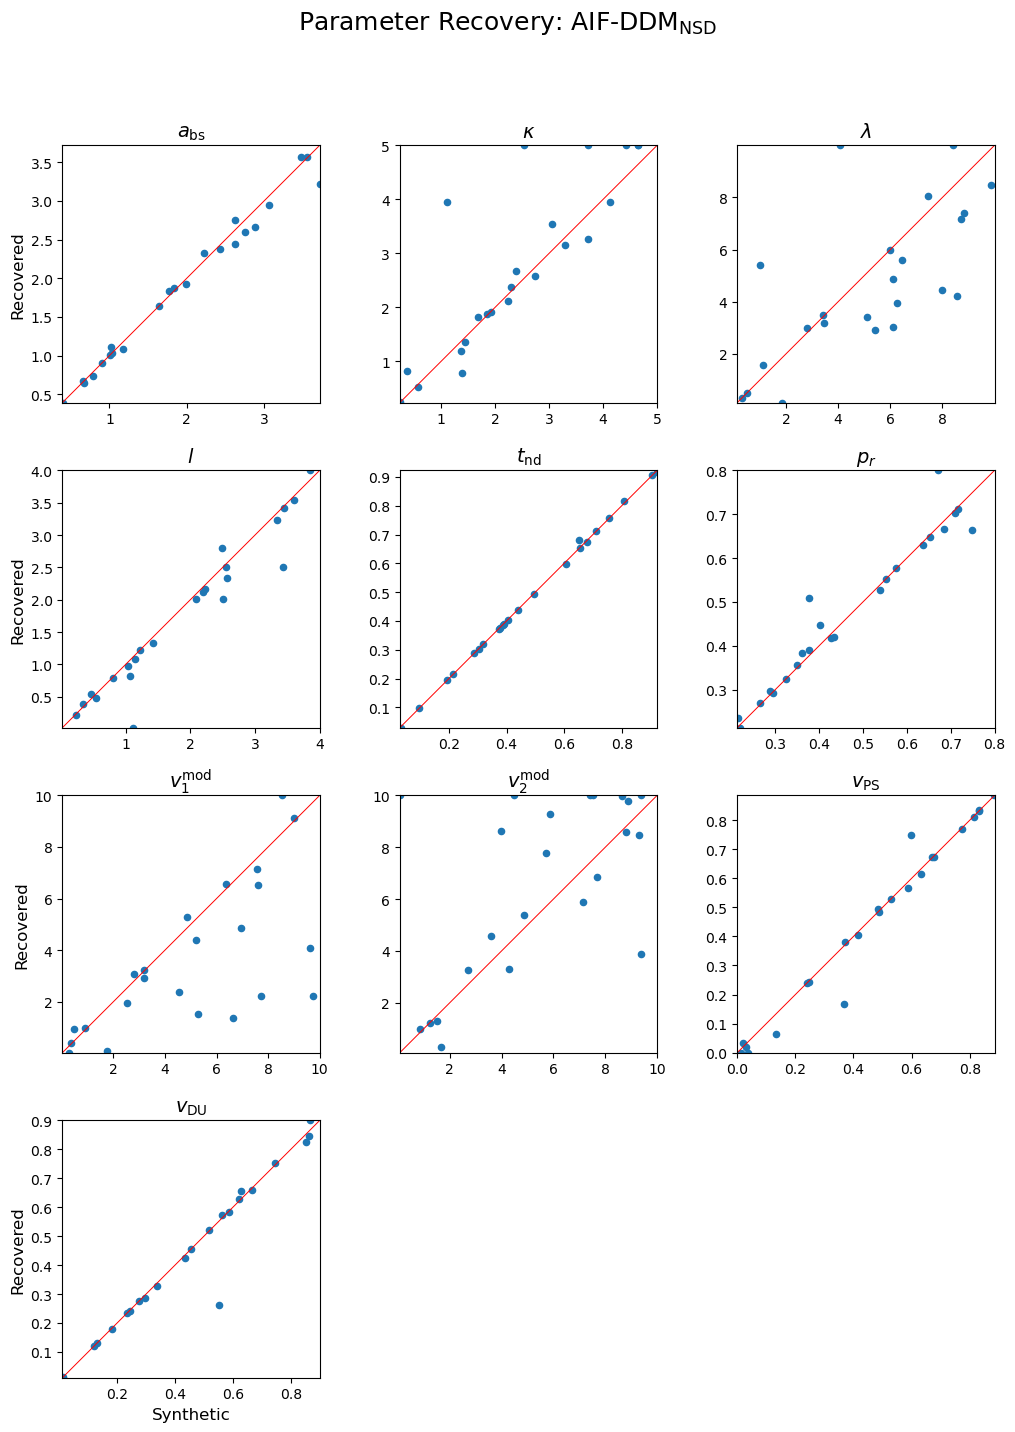

In [82]:
plot_parameter_recovery_results_grid(df_fitted_params, model= model, mtype=mtype, desired_rows=4)

In [117]:
df_pearson_corr = calculate_pearsons_correlations(df_fitted_params)

In [118]:
df_pearson_corr 

,Parameter,Pearson Correlation,p-value
0,lr,0.837686,6.14e-07
1,vsamp,0.927870,1.86e-10
2,vps,0.936451,5.1e-11
3,lam,0.789581,7.48e-06
4,kappa_a,0.926251,2.33e-10
5,prior_r,0.691683,0.000256
6,a_bs,0.948244,6.23e-12
7,ndt,0.999704,2.22e-35
8,v_stage_0,0.545158,0.00714
9,v_stage_1,0.596692,0.00265


In [119]:
df_fitted_params.columns

Index(['ParticipantID', 'NLL', 'Recovered_lr', 'Synthetic_lr',
       'Recovered_vsamp', 'Synthetic_vsamp', 'Recovered_vps', 'Synthetic_vps',
       'Recovered_lam', 'Synthetic_lam', 'Recovered_kappa_a',
       'Synthetic_kappa_a', 'Recovered_prior_r', 'Synthetic_prior_r',
       'Recovered_a_bs', 'Synthetic_a_bs', 'Recovered_ndt', 'Synthetic_ndt',
       'Recovered_v_stage_0', 'Synthetic_v_stage_0', 'Recovered_v_stage_1',
       'Synthetic_v_stage_1'],
      dtype='object')

## Plot correlations between different recovered parameters

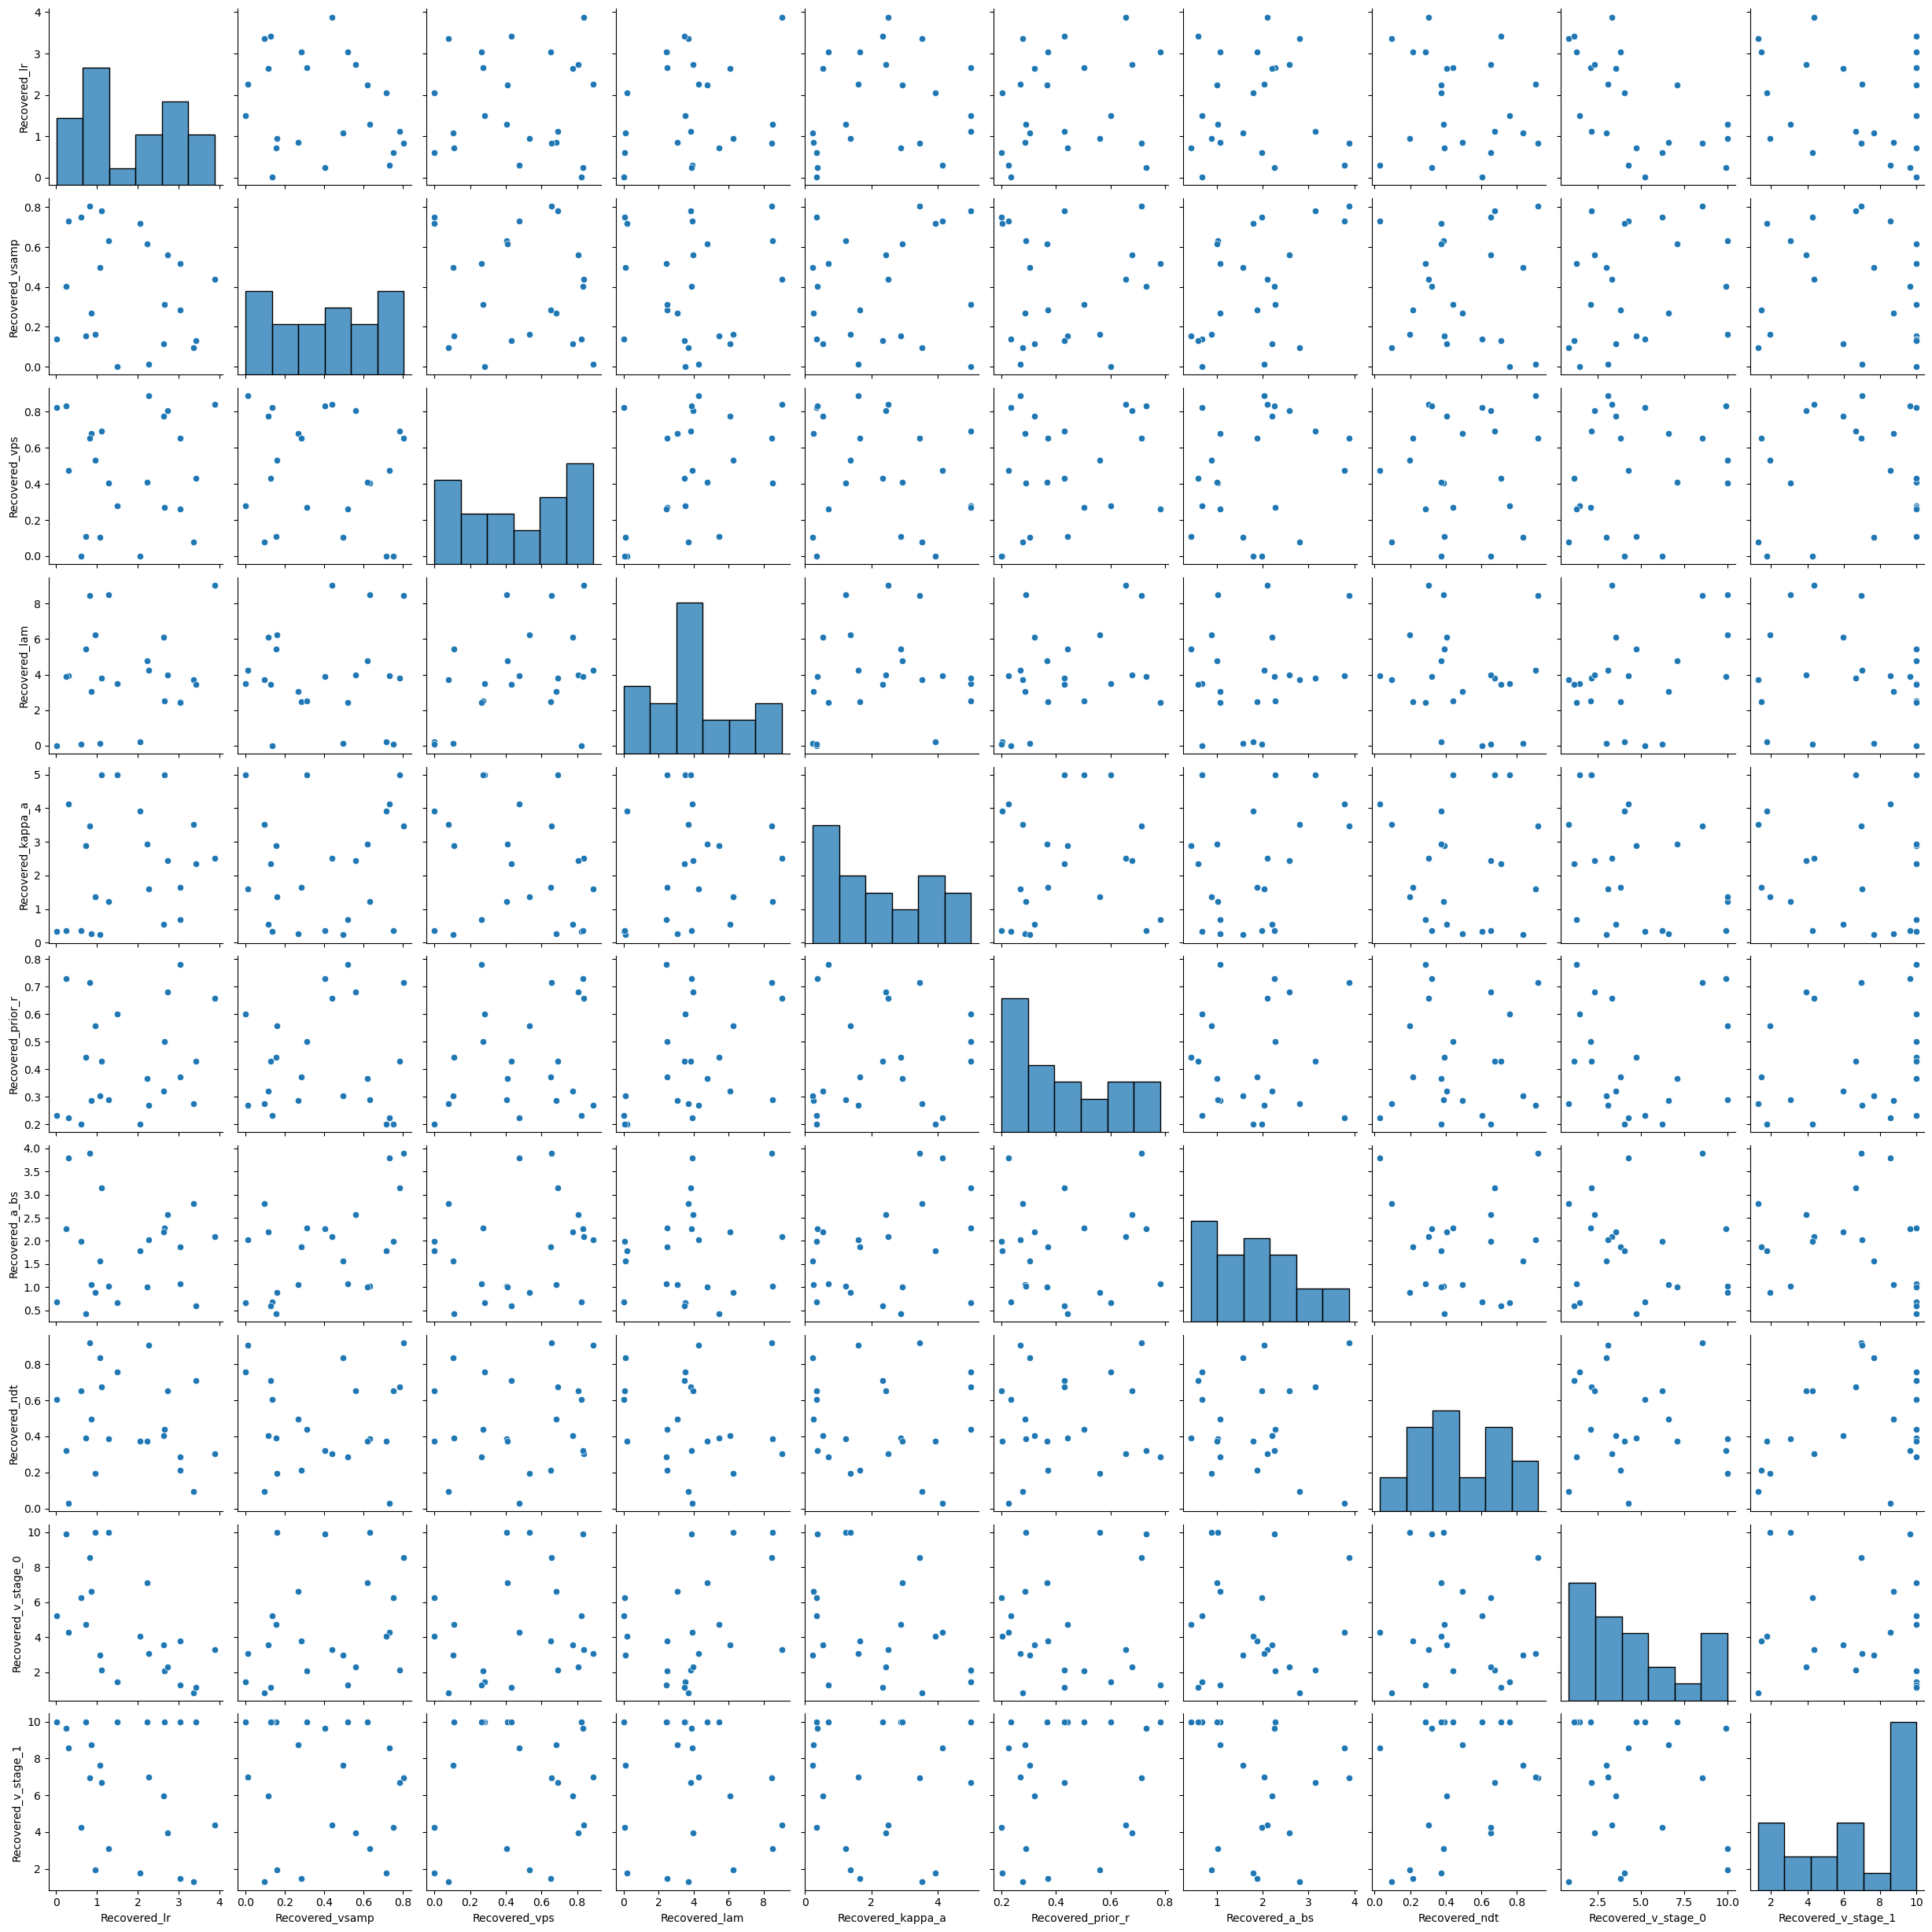

In [120]:
import seaborn as sns
import pandas as pd

# Assuming df_fitted_params is your DataFrame
# Filter columns that start with "Recovered_"
recovered_columns = [col for col in df_fitted_params.columns if col.startswith("Recovered_")]

# Select only those columns
df_recovered = df_fitted_params[recovered_columns]

# Create the pairplot
sns.pairplot(df_recovered)

# Paper plots